In [44]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs
titanic = sns.load_dataset("titanic")

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_4'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
savefigdir    = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'

drop_c = ['WSKT','SC1T','LL5T', 'GSAT'] 
# WSKT,SC1T,LL5T Young Females scanned extra for MRS review. 
# GSAT removed since HSPP female removed 
drop_p = ['AA8P', 'RA9P', 'STDP','NL2P','HSPP', 'DF2P'] 
# AA8P motion outliers via mehalonobis distance for Quality metrics 
# rest – mehalonobis distance for SN,STN,Puta


In [4]:
def cohen_d(df1,df2, metabolite):
        # Cohens D 
        from numpy import mean, std # version >= 1.7.1 && <= 1.9.1
        from math import sqrt
        import sys
        x = df1[metabolite].dropna(axis=0)
        y = df2[metabolite].dropna(axis=0)
        return (mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0)

def get_gender_len(df):    
    males   = [subject for subject in df.index if df.loc[subject]['Gender'] == 0]
    females = [subject for subject in df.index if df.loc[subject]['Gender'] == 1]
    return len(males), len(females)

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 
    
    
def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    

    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    
    
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 


# Look at age and gender

In [5]:
def get_gender_age_stats(df1, df2):
    
    gender = pd.DataFrame(index =['Controls', 'Patients'], columns = ['Male', 'Female'])

    gender.ix['Controls']['Male']   = get_gender_len(df1)[0]
    gender.ix['Controls']['Female'] = get_gender_len(df1)[1]
    gender.ix['Patients']['Male']   = get_gender_len(df2)[0]
    gender.ix['Patients']['Female'] = get_gender_len(df2)[1]

    print '--------------- Gender ---------------'
    print gender
    print ''
    print 'FISCHER EXACT TEST:', 'Odds Ratio=',np.round(fisher_exact(gender)[0],2), 'P-Value=',np.round(fisher_exact(gender)[1],2)
    print ''
    print '--------------- Age ---------------'
    print 'Controls Age = ', np.round(np.mean(controls_a.Age),2), '±', np.round(np.std(controls_a.Age),2)
    print 'Patients Age = ', np.round(np.mean(patients_a.Age),2), '±', np.round(np.std(patients_a.Age),2)
    print 'T-TEST =', ttest_ind(controls_a.Age.dropna(), patients_a.Age.dropna()) 
    
get_gender_age_stats(controls_a, patients_a)

--------------- Gender ---------------
         Male Female
Controls   17      5
Patients   18      4

FISCHER EXACT TEST: Odds Ratio= 0.76 P-Value= 1.0

--------------- Age ---------------
Controls Age =  38.59 ± 11.75
Patients Age =  35.59 ± 11.01
T-TEST = (0.85389486710538987, 0.39800739892709081)


# Look at Ferritin

In [6]:
def return_cln_df(population, study_id):
    df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_%s.csv'%(population,study_id)), index_col=0)
    return df   

Ferr_C = grubbs.test((return_cln_df('controls', 'a')['Ferritin'].dropna()))
Ferr_P = grubbs.test((return_cln_df('patients', 'a')['Ferritin'].dropna()))

Ferr_C = reject_outliers(get_all_dfs('QSM', 'controls', 'a')['CLN_Ferritin'], 3).dropna()
Ferr_P = reject_outliers(get_all_dfs('QSM', 'patients', 'a')['CLN_Ferritin'], 3).dropna().drop(['DF2P'], axis = 0)

#Ferr_C = controls_a['CLN_Ferritin'].dropna()
#Ferr_P = patients_a['CLN_Ferritin'].dropna()

#Ferr_C = grubbs.test(get_all_dfs('QSM', 'controls', 'a')['CLN_Ferritin'], 3).dropna()
#Ferr_P = grubbs.test(get_all_dfs('QSM', 'patients', 'a')['CLN_Ferritin'], 3).dropna()#.drop(['DF2P'], axis = 0)

print 'N=',len(Ferr_C), 'Controls Ferritin = ', np.round(np.median(Ferr_C),2), '±', np.round(np.std(Ferr_C),2)
print 'N=',len(Ferr_P), 'Patients Ferritin = ', np.round(np.median(Ferr_P),2), '±', np.round(np.std(Ferr_P),2)
print ''
print 'Kolmogrov-Smirnov test of Gaussian Distribution'
print 'Controls t/p=',kstest(preprocessing.scale(Ferr_C), 'norm')
print 'Patients t/p=:',kstest(preprocessing.scale(Ferr_P), 'norm')
print 'KS2Sample t/p=', ks_2samp(preprocessing.scale(Ferr_C), preprocessing.scale(Ferr_P))
print ''
print 'Levenes test of equal variance =',levene(Ferr_C, Ferr_P, center='median')
print ''
print 'Welches =', ttest_ind(Ferr_C, Ferr_P, equal_var = False)
print 'MWU =', mannwhitneyu(Ferr_C, Ferr_P)

N= 18 Controls Ferritin =  147.75 ± 151.26
N= 19 Patients Ferritin =  76.43 ± 48.8

Kolmogrov-Smirnov test of Gaussian Distribution
Controls t/p= (0.17492958886477183, 0.59506906877599142)
Patients t/p=: (0.14608297829830519, 0.81220137346759302)
KS2Sample t/p= (0.11988304093567248, 0.99853131563646835)

Levenes test of equal variance = (12.961208113703041, 0.0009750770927208092)

Welches = (2.7902687287555477, 0.011186959362303536)
MWU = (107.0, 0.026830356347729466)


(-200, 1000)

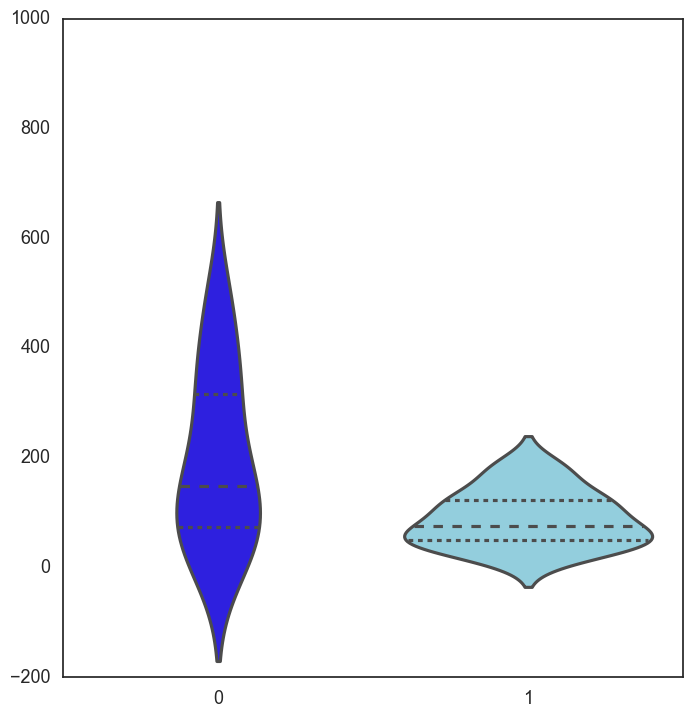

In [7]:
sns.set_style('white', {"xtick.direction": "in","ytick.direction": "in"})
data = [Ferr_C, Ferr_P] 
bpal = ["#1300ff", "#87d6e9"]
pal = sns.color_palette(bpal)
#palette = sns.color_palette("Paired")
#pal = [palette[1], palette[-1]]
jitter= 0.1
fontsize = 15

fig, ax = plt.subplots(1)
fig.set_size_inches([8,8.5])

#sns.boxplot(data = data, palette = pal)
sns.violinplot(data = data, palette = pal ,whis= 7, inner = 'quartile')#, scale='count')
#sns.stripplot(data = data, jitter= jitter,  palette = pal, size=10, linewidth=1, marker = '.')
#sns.pointplot(data=data, color = 'b', linestyles=['--'], markers=['o'])

#g.set_xticks([])
#g.set_yticks([0,2,4,6,8,10,12,14])
#ax.legend(frameon=False)
#sns.despine(left=True, bottom=True)
#ax.tick_params(axis='y', labelsize=fontsize)
plt.ylim(-200,1000)
#fname = os.path.join(savefigdir, 'Ferritin_stats.png')
#fig.savefig(fname , dpi = 300, bbox_inches='tight', transparent = False)

In [37]:
x = ['Controls', 'Patients']
y1 = [np.mean(Ferr_C), np.mean(Ferr_P)]
y2 = [np.std(Ferr_C), np.std(Ferr_P)]

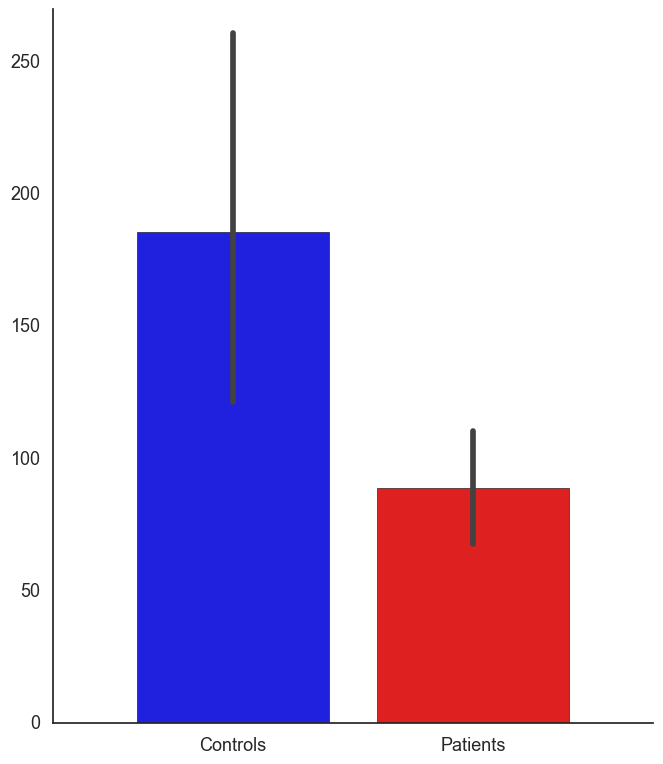

In [119]:
pd.DataFrame(columns=['Ferritin', 'Group'])
fc = pd.DataFrame(Ferr_C)
fp = pd.DataFrame(Ferr_P)
fc['group']   = 'Controls'
fp['group']   = 'Patients'
FERR =pd.concat([fc,fp])
xpal = ["#1300ff", "#87d6e9"]
#xpal =['#b5b8ff','#ffb3b9']

fig, ax = plt.subplots(1)
fig.set_size_inches([7,8])
g = sns.barplot(x="group", y="CLN_Ferritin", data=FERR,  palette=['b', 'r'])
#g = sns.barplot(x="group", y="CLN_Ferritin", data=FERR,  palette=xpal)
plt.xlim(-0.75, 1.75)
plt.ylim(0,270)
# Finalize the plot
sns.despine(bottom=False)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=3)
plt.xlabel('')
plt.ylabel('')

fig.savefig(os.path.join(savefigdir,'FERR_comparison.png'), bbox_inches='tight', transparent = 1)

In [45]:
cols = [ 'YGTSS_Total_Tic_Score', 'YGTSS_Motoric_Score', 'YGTSS_Vocal_Score', 'YGTSS_Total_Score_incl_Impairment',
        'RVTRS','puts','YBOCS_Totalscore_Items_1to10','YBOCS_Totalscore_Items_1to10_clinically_significant',
        'OCIR_total score','CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score','DSM4_clinically_significant_ADHD',
        'qol_scale','qol_score','BDI12']

# Look at Clinical data 

In [11]:
def make_bsl_demographic_table(dfc,dfp):
    columns = ['YGTSS_Total_Tic_Score', 'YGTSS_Motoric_Score', 'YGTSS_Vocal_Score', 'YGTSS_Total_Score_incl_Impairment',
               'RVTRS','puts','YBOCS_Totalscore_Items_1to10','OCIR_total score','qol_scale','qol_score','BDI12']
    cols = ['CLN_'+ i for i in columns]
    cols.append('STR_Gln_Glu')
    print cols
    rows = ['N' ,'Controls', 'Patients','Levene', 'KSC','KSP','D', 't_val', 'p_val']
    dfs= pd.DataFrame(index = rows, columns=cols)
    
    for col in cols:
        
        t_val, p_val = ttest_ind(dfc[col].dropna(), dfp[col].dropna())
        lvn          = levene(dfc[col].dropna(), dfp[col].dropna())
        ksc          = kstest(preprocessing.scale(dfc[col].dropna()), 'norm')
        ksp          = kstest(preprocessing.scale(dfp[col].dropna()), 'norm')
        dfs.ix['N'][col]        = len(dfc.index), len(dfp.index)
        dfs.ix['Controls'][col] = '%s±%s' %(np.round(np.mean(dfc[col].dropna()),2), np.round(np.std(dfc[col].dropna()),2)  )
        dfs.ix['Patients'][col] = '%s±%s' %(np.round(np.mean(dfp[col].dropna()),2), np.round(np.std(dfp[col].dropna()),2)  )
        dfs.ix['t_val'][col]    = np.round(t_val,2)
        dfs.ix['p_val'][col]    = np.round(p_val,6)
        dfs.ix['D'][col]        = np.round(cohen_d(dfc,dfp, col),2)
        dfs.ix['Levene'][col]   = np.round(lvn[1],2)
        dfs.ix['KSC'][col]      = np.round(ksc[1],2)
        dfs.ix['KSP'][col]      = np.round(ksp[1],2)
        
    return dfs.T

make_bsl_demographic_table(controls_a, patients_a)

['CLN_YGTSS_Total_Tic_Score', 'CLN_YGTSS_Motoric_Score', 'CLN_YGTSS_Vocal_Score', 'CLN_YGTSS_Total_Score_incl_Impairment', 'CLN_RVTRS', 'CLN_puts', 'CLN_YBOCS_Totalscore_Items_1to10', 'CLN_OCIR_total score', 'CLN_qol_scale', 'CLN_qol_score', 'CLN_BDI12', 'STR_Gln_Glu']


,N,Controls,Patients,Levene,KSC,KSP,D,t_val,p_val
CLN_YGTSS_Total_Tic_Score,"(21, 24)",0.0±0.0,20.17±8.86,0,0,0.39,-3.15,-9.94,0
CLN_YGTSS_Motoric_Score,"(21, 24)",0.0±0.0,13.08±4.22,0,0,0.49,-4.29,-13.54,0
CLN_YGTSS_Vocal_Score,"(21, 24)",0.0±0.0,7.08±5.96,0,0,0.41,-1.65,-5.19,6e-06
CLN_YGTSS_Total_Score_incl_Impairment,"(21, 24)",0.0±0.0,42.0±17.68,0,0,0.92,-3.29,-10.38,0
CLN_RVTRS,"(21, 24)",0.0±0.0,8.17±4.1,0,0,0.17,-2.76,-8.7,0
CLN_puts,"(21, 24)",0.0±0.0,19.29±5.82,0,0,0.99,-4.59,-14.48,0
CLN_YBOCS_Totalscore_Items_1to10,"(21, 24)",0.0±0.0,2.58±5.07,0.03,0,0,-0.7,-2.22,0.031533
CLN_OCIR_total score,"(21, 24)",6.0±6.32,15.71±13.42,0.09,0.47,0.05,-0.91,-2.9,0.00587
CLN_qol_scale,"(21, 24)",0.0±0.0,61.67±24.78,0,0,0.42,-3.45,-10.87,0
CLN_qol_score,"(21, 24)",0.0±0.0,29.62±20.11,0,0,0.42,-2.04,-6.44,0


In [12]:
def remove_nans_and_return_tuples(met1,met2):
    vlist = []
    for i in zip(np.array(met1), np.array(met2)):
        vlist.append(i)
    varray = np.array(vlist)
    varray = varray[~np.isnan(varray).any(1)]
    #print varray
    return varray

def make_paired_ttest(tuple_array):
        #Calculates the T-test on TWO RELATED samples of scores, a and b.
        #This is a two-sided test for the null hypothesis that 2 related or
        #repeated samples have identical average (expected) values.
        m1 = [i[0] for i in tuple_array]
        m2 = [i[1] for i in tuple_array]
        t_value, p_value = ttest_rel(np.array(m1), np.array(m2))
        t_value, p_value = wilcoxon(np.array(m1), np.array(m2))
        return np.round(t_value, 3), np.round(p_value, 3)

def make_trt_demographic_table(dfc,dfp):
    columns = ['YGTSS_Total_Tic_Score', 'YGTSS_Motoric_Score', 'YGTSS_Vocal_Score', 'YGTSS_Total_Score_incl_Impairment',
               'RVTRS','puts','YBOCS_Totalscore_Items_1to10','OCIR_total score','qol_scale','qol_score','BDI12']
    cols = ['CLN_'+ i for i in columns]
    cols.append('STR_Glx')
    rows = ['N','Patients_A', 'Patients_B','Levene', 'KSC','KSP','D', 't_val', 'p_val']
    dfs= pd.DataFrame(index = rows, columns=cols)
    
    for col in cols:
        tuple_array  = remove_nans_and_return_tuples(preprocessing.scale(dfc[col].dropna()), preprocessing.scale(dfp[col].dropna()))
        tuple_array  = remove_nans_and_return_tuples(dfc[col], dfp[col])

        t_val, p_val = make_paired_ttest(tuple_array)
        #t_val, p_val = mannwhitneyu(dfc[col].dropna(), dfp[col].dropna())
        lvn          = levene(dfc[col].dropna(), dfp[col].dropna())
        ksc          = kstest(preprocessing.scale(dfc[col].dropna()), 'norm')
        ksp          = kstest(preprocessing.scale(dfp[col].dropna()), 'norm')
        dfs.ix['N'][col] =  len(tuple_array)
        
        dfs.ix['Patients_A'][col] = '%s±%s' %(np.round(np.mean(dfc[col].dropna()),2), np.round(np.std(dfc[col].dropna()),2)  )
        dfs.ix['Patients_B'][col] = '%s±%s' %(np.round(np.mean(dfp[col].dropna()),2), np.round(np.std(dfp[col].dropna()),2)  )
        dfs.ix['t_val'][col]    = np.round(t_val,2)
        dfs.ix['p_val'][col]    = np.round(p_val,6)
        dfs.ix['D'][col]        = np.round(cohen_d(dfc,dfp, col),2)
        dfs.ix['Levene'][col]   = np.round(lvn[1],2)
        dfs.ix['KSC'][col]      = np.round(ksc[1],2)
        dfs.ix['KSP'][col]      = np.round(ksp[1],2)
        
    return dfs.T

make_trt_demographic_table(patients_a, patients_b)

/usr/local/lib/python2.7/site-packages/scipy/stats/morestats.py:1967: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,N,Patients_A,Patients_B,Levene,KSC,KSP,D,t_val,p_val
CLN_YGTSS_Total_Tic_Score,12,20.17±8.86,22.0±8.38,0.89,0.39,0.58,-0.21,16,0.441
CLN_YGTSS_Motoric_Score,12,13.08±4.22,13.83±3.53,0.8,0.49,0.96,-0.19,9,0.205
CLN_YGTSS_Vocal_Score,12,7.08±5.96,8.17±6.04,0.93,0.41,0.83,-0.17,20.5,0.812
CLN_YGTSS_Total_Score_incl_Impairment,12,42.0±17.68,49.25±18.23,0.65,0.92,0.98,-0.39,15,0.374
CLN_RVTRS,12,8.17±4.1,11.0±5.03,0.5,0.17,0.57,-0.59,14,0.312
CLN_puts,12,19.29±5.82,19.67±6.65,0.83,0.99,0.99,-0.06,19.5,0.722
CLN_YBOCS_Totalscore_Items_1to10,12,2.58±5.07,5.92±6.21,0.12,0,0.4,-0.57,1,0.08
CLN_OCIR_total score,12,15.71±13.42,16.67±11.59,0.8,0.05,0.22,-0.07,9,0.109
CLN_qol_scale,12,61.67±24.78,65.0±18.71,0.44,0.42,0.65,-0.15,18,0.594
CLN_qol_score,12,29.62±20.11,25.5±14.82,0.25,0.42,0.83,0.23,15.5,0.726
